# <center> Faster Optimizers <center>
---

Training a very large deep neural network can be painfully slow. So far we have seen
four ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using
Batch Normalization, and reusing parts of a pretrained network. Another huge speed
boost comes from using a faster optimizer than the regular Gradient Descent optimizer. In this section we will present the most popular ones: Momentum optimization, Nesterov Accelerated Gradient, AdaGrad, RMSProp, and finally Adam optimization.

## Momentum Optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start
out slowly, but it will quickly pick up momentum until it eventually reaches terminal
velocity (if there is some friction or air resistance). This is the very simple idea behind
Momentum optimization, proposed by Boris Polyak in 1964. In contrast, regular
Gradient Descent will simply take small regular steps down the slope, so it will take
much more time to reach the bottom.
Recall that Gradient Descent simply updates the weights θ by directly subtracting the
gradient of the cost function J(θ) with regards to the weights (∇θJ(θ)) multiplied by
the learning rate η. The equation is: θ ← θ – η∇θJ(θ). It does not care about what the
earlier gradients were. If the local gradient is tiny, it goes very slowly.
Momentum optimization cares a great deal about what previous gradients were: at
each iteration, it adds the local gradient to the momentum vector m (multiplied by the
learning rate η), and it updates the weights by simply subtracting this momentum
vector. In other words, the gradient is used as an acceleration, not
as a speed. To simulate some sort of friction mechanism and prevent the momentum
from growing too large, the algorithm introduces a new hyperparameter β, simply called the momentum, which must be set between 0 (high friction) and 1 (no friction).
A typical momentum value is 0.9.

Momentum algorithm
- m <- βm + η$∇_θ$J(θ)
- θ <- θ − m

You can easily verify that if the gradient remains constant, the terminal velocity (i.e.,
the maximum size of the weight updates) is equal to that gradient multiplied by the
learning rate η multiplied by 1 / (1 - β). For example, if β = 0.9, then the terminal velocity
is equal to 10 times the gradient times the learning rate, so Momentum optimization
ends up going 10 times faster than Gradient Descent! This allows Momentum optimization to escape from plateaus much faster than Gradient Descent. Gradient Descent goes down the
steep slope quite fast, but then it takes a very long time to go down the valley. In contrast, Momentum optimization will roll down the bottom of the valley faster and
faster until it reaches the bottom (the optimum). In deep neural networks that don’t
use Batch Normalization, the upper layers will often end up having inputs with very
different scales, so using Momentum optimization helps a lot. It can also help roll
past local optima.
Due to the momentum, the optimizer may overshoot a bit, then
come back, overshoot again, and oscillate like this many times
before stabilizing at the minimum. This is one of the reasons why it
is good to have a bit of friction in the system: it gets rid of these
oscillations and thus speeds up convergence.

Implementing Momentum optimization in TensorFlow is a no-brainer: just replace
the GradientDescentOptimizer with the MomentumOptimizer, then lie back and
profit!

In [ ]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
momentum=0.9)

The one drawback of Momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice
and almost always goes faster than Gradient Descent.

## Nesterov Accelerated Gradient

One small variant to Momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla Momentum optimization. The idea of Nesterov
Momentum optimization, or Nesterov Accelerated Gradient (NAG), is to measure the
gradient of the cost function not at the local position but slightly ahead in the direction of the momentum. The only difference from vanilla
Momentum optimization is that the gradient is measured at θ + βm rather than at θ.

Nesterov Accelerated Gradient algorithm
- m <- βm + η$∇_θ$J(θ + βm)
- θ <- θ − m

This small tweak works because in general the momentum vector will be pointing in
the right direction (i.e., toward the optimum), so it will be slightly more accurate to
use the gradient measured a bit farther in that direction rather than using the gradi‐
ent at the original position, as you can see in Figure 11-6 (where ∇1 represents the
gradient of the cost function measured at the starting point θ, and ∇2 represents the
gradient at the point located at θ + βm). As you can see, the Nesterov update ends up
slightly closer to the optimum. After a while, these small improvements add up and
NAG ends up being significantly faster than regular Momentum optimization. Moreover, note that when the momentum pushes the weights across a valley, ∇1 continues
to push further across the valley, while ∇2 pushes back toward the bottom of the valley. This helps reduce oscillations and thus converges faster.
NAG will almost always speed up training compared to regular Momentum optimization. To use it, simply set use_nesterov=True when creating the MomentumOptimizer:

In [ ]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
momentum=0.9, use_nesterov=True)

In [1]:
from IPython.display import Image

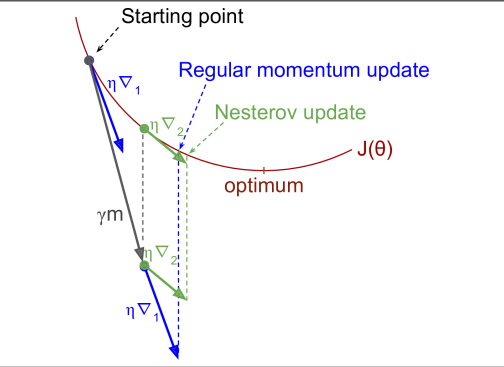

In [2]:
Image("/home/antonio/Dropbox/DataAnalysis/ToDoList/Primary/Deep_Learning/Tensorflow/Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow/Notebooks/NesterovMomentumOptimization.png")

## AdaGrad

Consider the elongated bowl problem again: Gradient Descent starts by quickly going
down the steepest slope, then slowly goes down the bottom of the valley. It would be
nice if the algorithm could detect this early on and correct its direction to point a bit
more toward the global optimum.
The AdaGrad algorithm achieves this by scaling down the gradient vector along the
steepest dimensions:

AdaGrad algorithm
- s <- s + $∇_θ$J(θ) ⊗ $∇_θ$J(θ)
- θ <- θ − η$∇_θ$J(θ) ⊘ $(s + \epsilon)^{0.5}$ 

The first step accumulates the square of the gradients into the vector s (the ⊗ symbol
represents the element-wise multiplication). This vectorized form is equivalent to computing $s_i ← s_i + (∂ / ∂ θ_i J(θ))^2$ for each element si of the vector s; in other words,
each $s_i$ accumulates the squares of the partial derivative of the cost function with
regards to parameter $θ_i$. If the cost function is steep along the ith dimension, then $s_i$
will get larger and larger at each iteration.
The second step is almost identical to Gradient Descent, but with one big difference:
the gradient vector is scaled down by a factor of $(s + \epsilon)^{0.5}$ (the ⊘ symbol represents the
element-wise division, and $\epsilon$ is a smoothing term to avoid division by zero, typically
set to $10^{–10}$). This vectorized form is equivalent to computing
$θ_i <- θ_i − η ∂/∂θi J(θ) / (s_i + \epsilon)^{0.5}$ for all parameters $θ_i$ (simultaneously).
In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate.
It helps point the resulting updates more directly toward the global optimum. One additional benefit is that it requires much less tuning of the learning rate hyperparameter η.

**AdaGrad often performs well for simple quadratic problems, but unfortunately it
often stops too early when training neural networks. The learning rate gets scaled
down so much that the algorithm ends up stopping entirely before reaching the
global optimum. So even though TensorFlow has an AdagradOptimizer, you should
not use it to train deep neural networks (it may be efficient for simpler tasks such as
Linear Regression, though).**

## RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the
global optimum, the RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step.

RMSProp algorithm
- s <- βs + (1 − β) $∇_θ$J(θ) ⊗ $∇_θ$J(θ)
- θ <- θ − η$∇_θ$J(θ) ⊘ $(s + \epsilon)^{0.5}$ 

The decay rate β is typically set to 0.9. Yes, it is once again a new hyperparameter, but
this default value often works well, so you may not need to tune it at all.
As you might expect, TensorFlow has an RMSPropOptimizer class:

In [ ]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
momentum=0.9, decay=0.9, epsilon=1e-10)

**Except on very simple problems, this optimizer almost always performs much better
than AdaGrad. It also generally converges faster than Momentum optimization and
Nesterov Accelerated Gradients. In fact, it was the preferred optimization algorithm
of many researchers until Adam optimization came around.**

## Adam Optimization

Adam, which stands for adaptive moment estimation, combines the ideas of Momentum optimization and RMSProp: just like Momentum optimization it keeps track of
an exponentially decaying average of past gradients, and just like RMSProp it keeps
track of an exponentially decaying average of past squared gradients.

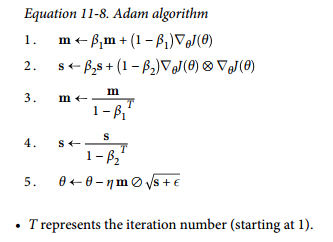

In [3]:
Image("/home/antonio/Dropbox/DataAnalysis/ToDoList/Primary/Deep_Learning/Tensorflow/Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow/Notebooks/AdamAlgorithm.png")

If you just look at steps 1, 2, and 5, you will notice Adam’s close similarity to both
Momentum optimization and RMSProp. The only difference is that step 1 computes
an exponentially decaying average rather than an exponentially decaying sum, but
these are actually equivalent except for a constant factor (the decaying average is just
1 – $β_1$ times the decaying sum). Steps 3 and 4 are somewhat of a technical detail: since
m and s are initialized at 0, they will be biased toward 0 at the beginning of training,
so these two steps will help boost m and s at the beginning of training.
The momentum decay hyperparameter $β_1$ is typically initialized to 0.9, while the scal‐
ing decay hyperparameter $β_2$ is often initialized to 0.999. As earlier, the smoothing
term ϵ is usually initialized to a tiny number such as $10^{–8}$. These are the default values
for TensorFlow’s AdamOptimizer class, so you can simply use:

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In fact, since Adam is an adaptive learning rate algorithm (like AdaGrad and
RMSProp), it requires less tuning of the learning rate hyperparameter η. You can
often use the default value η = 0.001, making Adam even easier to use than Gradient
Descent.

All the optimization techniques discussed so far only rely on the first-order partial
derivatives (Jacobians). The optimization literature contains amazing algorithms
based on the second-order partial derivatives (the Hessians). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are $n^2$ Hessians
per output (where n is the number of parameters), as opposed to just n Jacobians per
output. Since DNNs typically have tens of thousands of parameters, the second-order
optimization algorithms often don’t even fit in memory, and even when they do,
computing the Hessians is just too slow.

## Learning Rate Scheduling

Finding a good learning rate can be tricky. If you set it way too high, training may
actually diverge. If you set it too low, training will
eventually converge to the optimum, but it will take a very long time. If you set it
slightly too high, it will make progress very quickly at first, but it will end up dancing
around the optimum, never settling down (unless you use an adaptive learning rate
optimization algorithm such as AdaGrad, RMSProp, or Adam, but even then it may
take time to settle). If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.

You may be able to find a fairly good learning rate by training your network several
times during just a few epochs using various learning rates and comparing the learning curves. The ideal learning rate will learn quickly and converge to good solution.
However, you can do better than a constant learning rate: if you start with a high
learning rate and then reduce it once it stops making fast progress, you can reach a
good solution faster than with the optimal constant learning rate. There are many dif‐
ferent strategies to reduce the learning rate during training. These strategies are called
learning schedules, the most com‐
mon of which are:
- **Predetermined piecewise constant learning rate.** For example, set the learning rate to $η_0$ = 0.1 at first, then to $η_1$ = 0.001 after 50 epochs. Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.
- **Performance scheduling.** Measure the validation error every N steps (just like for early stopping) and reduce the learning rate by a factor of λ when the error stops dropping.
- **Exponential scheduling.** Set the learning rate to a function of the iteration number t: $η(t) = η_0 10^{–t/r}$. This works great, but it requires tuning $η_0$ and r. The learning rate will drop by a factor of 10 every r steps.
- **Power scheduling.** Set the learning rate to $η(t) = η_0 (1 + t/r)^{–c}$. The hyperparameter c is typically set to 1. This is similar to exponential scheduling, but the learning rate drops much more slowly.

A 2013 paper by Andrew Senior et al. compared the performance of some of the
most popular learning schedules when training deep neural networks for speech recognition using Momentum optimization. The authors concluded that, in this setting,
both **performance scheduling and exponential scheduling performed well, but they
favored exponential scheduling because it is simpler to implement, is easy to tune,
and converged slightly faster to the optimal solution.**

Implementing a learning schedule with TensorFlow is fairly straightforward:

In [ ]:
initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                            decay_steps, decay_rate)
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
training_op = optimizer.minimize(loss, global_step=global_step)

After setting the hyperparameter values, we create a nontrainable variable
global_step (initialized to 0) to keep track of the current training iteration number.
Then we define an exponentially decaying learning rate (with $η_0$ = 0.1 and r = 10,000)
using TensorFlow’s exponential_decay() function. Next, we create an optimizer (in
this example, a MomentumOptimizer) using this decaying learning rate. Finally, we create the training operation by calling the optimizer’s minimize() method; since we
pass it the global_step variable, it will kindly take care of incrementing it. That’s it!
Since AdaGrad, RMSProp, and Adam optimization automatically reduce the learning
rate during training, it is not necessary to add an extra learning schedule. For other
optimization algorithms, using exponential decay or performance scheduling can
considerably speed up convergence.